<a id="top"></a>
# Content


### 1. [Map Reduce](#map-reduce)

### 2. [Short Term vs Long Term Memory](#short-term-vs-long-term-memory)

### 3. [Chatbot with Profile Schema](#chatbot-with-profile-schema)

### 4. [Chatbot with Profile Collection](#chatbot-with-profile-collection)


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [18]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from src.utilities.llm_utils import (
    LLMResponse,
    convert_to_openai_messages,
)  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [5]:
check_rate_limit()

{
  "data": {
    "label": "sk-or-v1-902...c45",
    "limit": 5,
    "usage": 3.7253450895,
    "is_provisioning_key": false,
    "limit_remaining": 1.2746549104999998,
    "is_free_tier": false,
    "rate_limit": {
      "requests": 20,
      "interval": "10s"
    }
  }
}


In [6]:
from typing import Any, Type

from pydantic import BaseModel, SecretStr


def validate_data(
    data: dict[str, Any], state: dict[str, Any], response_model: Type[BaseModel]
) -> None:
    """Validate that input data matches the expected response model structure.

    Parameters
    ----------
    data : dict[str, Any]
        The input data dictionary to validate
    state : dict[str, Any]
        The state dictionary to update with input data
    response_model : Type[BaseModel]
        The Pydantic model class to validate against

    Returns
    -------
    None
        Function performs validation through assertions

    Raises
    ------
    AssertionError
        If data is not a dictionary, state is not a dictionary, or fails model validation
    """
    assert isinstance(data, dict), "Data must be a dictionary"
    assert isinstance(state, dict), "Data must be a dictionary"
    state.update(data)

    assert response_model(**state), "Data is not valid"

<br>

### LangGraph Imports

In [7]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langchain_tavily import TavilySearch
from langfuse.langchain import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

In [8]:
from langchain_core.language_models.chat_models import BaseChatModel

subject_prompt: str = """
<system>

Generate a list of 3 sub-topics that are all 
related to this overall topic:

<topic>
{topic!r} 
</topic>

</system>
"""

joke_prompt: str = """
<system>
Generate a joke about:

<subject>
{subject!r}
</subject>

</system>
"""

best_joke_prompt: str = """
<system>
Below are a bunch of jokes about:

<topic>
{topic!r}.
</topic>

Select the best one! Return the ID of the best one, starting 0 
as the ID for the first joke. 
<jokes>
{jokes}
</jokes>

<output>
Return the ID of the best joke as an integer.
</output>

</system>
"""

### Initialize the LLM

In [14]:
llm = LLMResponse(
    api_key=settings.OPENROUTER_API_KEY,
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE,
)
console.print(llm)

LLMResponse(
    api_key=SecretStr('**********'),
    base_url='https://openrouter.ai/api/v1',
    model=<ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE: 'meta-llama/llama-3.2-3b-instruct'>
)

In [15]:
messages: list[dict[str, str]] = [
    {
        "role": "system",
        "content": subject_prompt.format(topic="Types of animals"),
    }
]

await llm.ainvoke(messages=messages)

'Here are 3 sub-topics related to the overall topic "Types of animals":\n\n<system>\n\n<topic>\n\'Mammals\'\n</topic>\n\n<topic>\n\'Insects\'\n</topic>\n\n<topic>\n\'Fish and Aquatic Animals\'\n</topic>\n\n</system>'

## Parallelizing Joke Generation

- Define a graph that will:
  - take a user input topic
  - produce a list of joke topics fro it
  - send each joke topic to the LLM
- The state has a `jokes` key that will accumulate jokes from parallelized joke generations.

In [16]:
from pydantic import BaseModel, Field


class Subjects(BaseModel):
    subjects: list[str] = Field(description="List of subjects related to the topic.")


class BestJoke(BaseModel):
    id: int = Field(description="ID of the best joke selected from the list of jokes.")


class OverallState(TypedDict):
    topic: str
    subjects: list[str]
    jokes: Annotated[list[str], add_messages]
    best_selected_joke: str


class JokeState(TypedDict):
    subject: str


class Joke(BaseModel):
    joke: str

#### Test The Code

In [17]:
# Using a custom structured output model
structured_output, raw_response = await llm.get_structured_response(
    message=subject_prompt.format(topic="types of animals"),
    response_model=Subjects,
)
console.print(raw_response)
print("----" * 50)
console.print(structured_output)

ChatCompletion(
    id='gen-1750536955-4fvPB925EfQZj691UyI1',
    choices=[
        Choice(
            finish_reason='stop',
            index=0,
            logprobs=None,
            message=ChatCompletionMessage(
                content='{"subjects": ["Mammals", "Birds", "Reptiles"]}',
                refusal=None,
                role='assistant',
                annotations=None,
                audio=None,
                function_call=None,
                tool_calls=None,
                reasoning=None
            ),
            native_finish_reason='stop'
        )
    ],
    created=1750536957,
    model='meta-llama/llama-3.2-3b-instruct',
    object='chat.completion',
    service_tier=None,
    system_fingerprint=None,
    usage=CompletionUsage(
        completion_tokens=18,
        prompt_tokens=299,
        total_tokens=317,
        completion_tokens_details=None,
        prompt_tokens_details=None
    ),
    provider='Together'
)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Subjects(subjects=['Mammals', 'Birds', 'Reptiles'])

In [ ]:
async def generate_topics(state: OverallState) -> dict[str, Any]:
    """Generate a list of subjects based on a given topic.

    Parameters
    ----------
        state (OverallState): The current state containing the topic to generate subjects for.
            Expected to have a 'topic' key with a string value.

    Returns
    -------
        dict[str, Any]

    """
    prompt: str = subject_prompt.format(topic=state["topic"])

    response, _ = await llm.get_structured_response(message=prompt, response_model=Subjects)
    return {"subjects": response.subjects}

In [23]:
await generate_topics({"topic": "Types of animals"})

{'subjects': ['Mammals', 'Birds', 'Reptiles']}

### Send Function

- In LangGraph, Nodes and Edges usually share a predefined state. However, for dynamic cases like map-reduce, LangGraph uses `Send` objects in conditional edges.
- It can be used to parallelize tasks.

In [ ]:
from langgraph.constants import Send


def continue_to_jokes(state: OverallState) -> list[Send]:
    """
    Generate N number of jokes in parallel by sending them to the required nodes.

    Parameters
    ----------
    state : OverallState
        The current state containing subjects for joke generation.

    Returns
    -------
    list[Send]
    """
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


async def generate_joke(state: JokeState) -> dict[str, Any]:
    prompt: str = joke_prompt.format(subject=state["subject"])
    response, _ = await llm.get_structured_response(message=prompt, response_model=Joke)

    return {"jokes": [response.joke]}


async def select_best_joke(state: OverallState) -> dict[str, Any]:
    """
    Select the best joke from a list of jokes based on a given topic.
    This is a reduction step.

    Parameters
    ----------
    state : OverallState
        The current state containing jokes and topic for selection.
        Expected keys:
            - jokes: list[str | HumanMessage]
            - topic: str

    Returns
    -------
    dict[str, Any]
        Dictionary containing the best selected joke.
        Keys:
            - best_selected_joke: str
    """
    if isinstance(state["jokes"][0], HumanMessage):
        state["jokes"] = [j.content for j in state["jokes"]]
    jokes: str = "\n\n".join(state["jokes"])
    prompt: str = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response, _ = await llm.get_structured_response(message=prompt, response_model=BestJoke)

    return {"best_selected_joke": state["jokes"][response.id]}

In [27]:
_jokes: list[str] = [
    "Why do seagulls fly over the sea?",
    "Why dont mammals ever get locked out of their homes? Because "
    "they always carry their keys with them!",
    "Why dont reptiles ever forget? Because no one ever lizard them a thing!",
]

jokes: str = "\n\n".join(_jokes)
prompt: str = best_joke_prompt.format(topic="types of animals", jokes=jokes)
print("==== Prompt for selecting the best joke: ====")
print(prompt)
resp, _ = await llm.get_structured_response(message=prompt, response_model=BestJoke)
print("==== Response for selecting the best joke: ====")
print(resp.id)
result = {"best_selected_joke": _jokes[resp.id]}
print("==== Best joke selected: ====")
print(f"{result = }")

==== Prompt for selecting the best joke: ====

<system>
Below are a bunch of jokes about:

<topic>
'types of animals'.
</topic>

Select the best one! Return the ID of the best one, starting 0 
as the ID for the first joke. 
<jokes>
Why do seagulls fly over the sea?

Why dont mammals ever get locked out of their homes? Because they always carry their keys with them!

Why dont reptiles ever forget? Because no one ever lizard them a thing!
</jokes>

<output>
Return the ID of the best joke as an integer.
</output>

</system>

==== Response for selecting the best joke: ====
0
==== Best joke selected: ====
result = {'best_selected_joke': 'Why do seagulls fly over the sea?'}


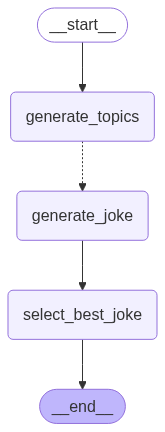

In [28]:
graph_builder = StateGraph(OverallState)

# Add nodes
graph_builder.add_node("generate_topics", generate_topics)
graph_builder.add_node("generate_joke", generate_joke)
graph_builder.add_node("select_best_joke", select_best_joke)

# Add edges
graph_builder.add_edge(START, "generate_topics")
graph_builder.add_conditional_edges(
    "generate_topics",
    # Generate jokes in parallel by `Sending` the jokes the `generate_joke` node
    continue_to_jokes,
    ["generate_joke"],
)
graph_builder.add_edge("generate_joke", "select_best_joke")
graph_builder.add_edge("select_best_joke", END)

# Compile the graph
graph = graph_builder.compile().with_config(run_name="Generate Jokes")

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

<br>

### Test The Graph

In [29]:
topic: str = "types of animals"

async for s in graph.astream({"topic": topic}):
    print(s)

{'generate_topics': {'subjects': ['Mammals', 'Birds', 'Reptiles']}}
{'generate_joke': {'jokes': ['Why did the snake visit the doctor? Because it had a hissy fit!']}}
{'generate_joke': {'jokes': ['Why did the mammal go to the party? Because he heard it was a hair-raising experience!']}}
{'generate_joke': {'jokes': ['Why did the bird go to the doctor? It had a fowl cough!']}}
{'select_best_joke': {'best_selected_joke': 'Why did the mammal go to the party? Because he heard it was a hair-raising experience!'}}


<a id="short-term-vs-long-term-memory"></a>
# 2. Short Term vs Long Term Memory

## Memory

- Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

- There are various long-term memory types that can be used in AI applications.
- We'll build a chatbot that uses both `short-term` (within-thread) and `long-term` (across-thread) memory.
- We'll focus on long-term semantic memory, which will be facts about the user.
- These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

### LangGraph Store

- The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information across threads in LangGraph.
- This is an open source base class for persistent key-value stores.

- When storing objects (e.g., memories) in the Store, we provide:
  - The `namespace` for the object, a tuple (similar to directories)
  - the `object key` (similar to filenames)
  - the `object value` (similar to file contents)
  - We use the `put` method to save an object to the store by `namespace` and `key`.

In [30]:
import uuid

from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

# Create a namespace to store the data
user_id: str = "1"
prefix: str = "memories"
namespace_for_memory: tuple[str, str] = (prefix, user_id)
key: str = str(uuid.uuid4())

# The value MUST be a dictionary
value: dict[str, Any] = {"food_preference": "I like pizza"}

# Save the data
in_memory_store.put(namespace_for_memory, key, value)

#### Search

In [31]:
memories = in_memory_store.search(namespace_for_memory)
console.log(memories)

[21:31:43] [                                                                                        ]8;id=806108;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_21152/1831516903.py\1831516903.py]8;;\:]8;id=606871;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_21152/1831516903.py#2\2]8;;\
               Item(namespace=['memories', '1'], key='be0fc070-d5ac-4d27-b1e9-18841e6765dc',                       
           value={'food_preference': 'I like pizza'},                                                              
           created_at='2025-06-21T20:31:40.463715+00:00',                                                          
           updated_at='2025-06-21T20:31:40.463719+00:00', score=None)                                              
           ]                                                                                                       

In [32]:
memories[0].dict()

{'namespace': ['memories', '1'],
 'key': 'be0fc070-d5ac-4d27-b1e9-18841e6765dc',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-21T20:31:40.463715+00:00',
 'updated_at': '2025-06-21T20:31:40.463719+00:00',
 'score': None}

#### Get

In [33]:
memories = in_memory_store.get(namespace_for_memory, key)
memories.dict()

{'namespace': ['memories', '1'],
 'key': 'be0fc070-d5ac-4d27-b1e9-18841e6765dc',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-21T20:31:40.463715+00:00',
 'updated_at': '2025-06-21T20:31:40.463719+00:00'}

<br><br>

### Chatbot With Long Term Memory

- We want a chatbot that has two types of memory:
  - **Short-term (within-thread) memory**: Chatbot can persist conversational history and / or allow interruptions in a chat session.
  - **Long-term (cross-thread) memory**: Chatbot can remember information about a specific user across all chat sessions.

In [34]:
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore

In [35]:
class DataState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class DataStateValidator(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [36]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE: str = """
<system>

<role>
You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
</role>

<memory>
{memory}
</memory>

<quality_standards>
- **ALWAYS** use the information in memory.
</quality_standards>

</system>
"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION: str = """"
<system>

<role>
You are collecting information about the user to personalize your responses.
</role>

<current_user_info>
{memory}
</current_user_info>

<instruction>
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version
Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.
</instruction>

Based on the chat history below, please update the user information:

<system>
"""

### Initialize the LLM

In [37]:
llm = LLMResponse(
    api_key=settings.OPENROUTER_API_KEY,
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE,
)
console.print(llm)

LLMResponse(
    api_key=SecretStr('**********'),
    base_url='https://openrouter.ai/api/v1',
    model=<ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE: 'meta-llama/llama-3.2-3b-instruct'>
)

In [ ]:
async def call_llm(state: DataState, config: RunnableConfig, store: BaseStore) -> dict[str, Any]:
    # Get the user id
    user_id = config["configurable"]["user_id"]

    # Get the memory for the user
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get(prefix)
    else:
        existing_memory_content = "No existing memory found"

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    # Respond using memory + chat history
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response = await llm.ainvoke(messages=formatted_messages)

    return {"messages": [response]}


async def write_memory(state: DataState, config: RunnableConfig, store: BaseStore) -> None:
    user_id = config["configurable"]["user_id"]
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get(prefix)
    else:
        existing_memory_content = "No existing memory found"

    system_message: str = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    # Respond using memory + chat history
    new_memory = await llm.ainvoke(messages=formatted_messages)

    # Update existing memory
    # await store.aput(namespace, key, {prefix: new_memory.content})
    store.put(namespace, key, {prefix: new_memory})

In [69]:
await call_llm(
    state={"messages": [HumanMessage(content="What is my favorite food?")]},
    config={"configurable": {"thread_id": "1", "user_id": "1"}},
    store=in_memory_store,
)

{'messages': ["I don't have any information about your preferences or memories. This is the start of our conversation, and I don't have any data about you. Would you like to share your favorite food with me?"]}

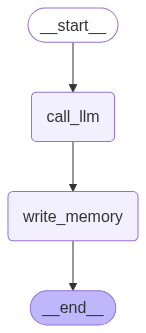

In [72]:
# Graph
graph_builder = StateGraph(DataState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="chatbot-with-memory")

# Visualize
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [73]:
config: dict[str, Any] = {"configurable": {"thread_id": "1", "user_id": "1"}}
msgs = ["Hello, my name is Neidu"]
input_state = DataState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our interaction, so everything we chat about will be a new start. How can I assist you today, Neidu?


In [74]:
msgs = ["I'm an AI Engineer whos's currently working on NLP related things"]
input_state = DataState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our interaction, so everything we chat about will be a new start. How can I assist you today, Neidu?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our inter

In [75]:
msgs = ["What do you know about me so far?"]
input_state = DataState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our interaction, so everything we chat about will be a new start. How can I assist you today, Neidu?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================ Human Message =================================

That's fascinating, Neidu! As an AI Engineer working on NLP, I'm sure you're always looking for ways to improve and push the boundaries of natural language understanding.

What specific area of NLP are you currently focusing on? Are you working on tasks such as text classification, sentiment analy

In [76]:
# Chat history
state = graph.get_state(config=config).values

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our interaction, so everything we chat about will be a new start. How can I assist you today, Neidu?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================ Human Message =================================

That's fascinating, Neidu! As an AI Engineer working on NLP, I'm sure you're always looking for ways to improve and push the boundaries of natural language understanding.

What specific area of NLP are you currently focusing on? Are you working on tasks such as text classification, sentiment analy

In [78]:
# namespace for the memory to save
user_id: str = "1"
prefix: str = "memory"
key = "user_memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.get(namespace, key)
console.print(existing_memory.dict())

{
    'namespace': ['memory', '1'],
    'key': 'user_memory',
    'value': {
        'memory': "That's a great summary, thank you for keeping track of our conversation! I'm glad to see that 
you've picked up on my enthusiasm for NLP and conversational AI.\n\nTo add a bit more to the summary, I can tell 
you that I'm currently working on a project that involves developing a conversational AI system for customer 
service applications. My goal is to create a system that can understand and respond to user queries in a way that's
natural, intuitive, and empathetic.\n\nAs for what sparked my interest in NLP, I have to say that it was a 
combination of my background in computer science and my passion for language and communication. I've always been 
fascinated by the way humans interact with each other, and I saw NLP as a way to bridge the gap between humans and 
machines.\n\nI'm excited about the potential to create systems that can truly understand and respond to human 
emotions, needs, and context. I believe that conversational AI has the potential to revolutionize the way we 
interact with machines, and I'm eager to be a part of that revolution.\n\nWhat about you? What draws you to NLP, 
and what are some of the most exciting developments you've seen in the field recently?"
    },
    'created_at': '2025-06-21T20:55:48.196387+00:00',
    'updated_at': '2025-06-21T20:55:48.196392+00:00'
}

#### Use Another Thread

- The chatbot is now in a different thread and has no context of the previous conversation.

In [79]:
config_2: dict[str, Any] = {"configurable": {"thread_id": "2", "user_id": "1"}}
msgs = ["What do you know about me so far?"]
input_state = DataState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config_2, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

What do you know about me so far?
================================ Human Message =================================

What do you know about me so far?
================================ Human Message =================================

I don't have any information about you beyond what you've shared with me in our conversation so far. You haven't told me much about yourself, and I don't have any prior knowledge about you. Our conversation just started, and I'm here to help answer any questions you may have or provide information on a topic you're interested in. What would you like to talk about?


<a id="chatbot-with-profile-schema"></a>

# Chatbot with Profile Schema

- We introduced the LangGraph Memory Store as a way to save and retrieve long-term memories.
- We built a simple chatbot that uses both short-term (within-thread) and long-term (across-thread) memory.
- It saved long-term semantic memory (facts about the user) "in the hot path", as the user is chatting with it.
- Our chatbot saved memories as a string. In practice, we often want memories to have a structure.


## Profiles

- For example, memories can be a single, continuously updated schema.
- In our case, we want this to be a single user profile.

- We'll extend our chatbot to save semantic memories to a single user profile.

- We'll also introduce a library, `Trustcall`, to update this schema with new information.

### [Go to top](#top)

In [95]:
# Using TypedDict


class UserProfile(BaseModel):
    user_name: str = Field(description="User's preferred name")
    interests: list[str] = Field(description="List of user's interests")


# Save a schema to the store
user_profile = UserProfile(
    user_name="Neidu", interests=["AI", "NLP", "Spiritual Growth"]
)
user_profile

UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'Spiritual Growth'])

In [96]:
# Create a store
in_memory_store = InMemoryStore()

user_id: str = "1"
prefix: str = "memory"
key = "user_profile"
namespace = (prefix, user_id)
across_thread_memory.put(namespace, key, user_profile)

in_memory_store.put(namespace, key, user_profile)

In [97]:
# Retrieve the data

for data in in_memory_store.search(namespace):
    console.print(data.dict())

{
    'namespace': ['memory', '1'],
    'key': 'user_profile',
    'value': UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'Spiritual Growth']),
    'created_at': '2025-06-21T21:31:52.332716+00:00',
    'updated_at': '2025-06-21T21:31:52.332718+00:00',
    'score': None
}

## Chatbot With Profile Schema

In [98]:
# Let's test the user profile with structured outputs
message: str = (
    "I'm Neidu and I'm a AI Engineer. I love working on AI and NLP "
    "related projects. I'm also looking for spiritual growth."
)

response, _ = await llm.get_structured_response(
    message=message, response_model=UserProfile
)
console.log(response)

[22:32:00] UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'spiritual growth'])              ]8;id=133308;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_21152/2327894213.py\2327894213.py]8;;\:]8;id=896376;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_21152/2327894213.py#8\8]8;;\

In [ ]:
# class UserProfile(BaseModel):
#     user_name: str  # User's preferred name
#     other_personal_details: Annotated[list[str], add_messages] = Field(
#         default_factory=list, description="Other personal details. e.g. location"
#     )
#     interests: list[str] = Field(default_factory=list, description="User's interests")
#     preferences: list[str] = Field(default_factory=list, description="Likes, dislikes, etc.")

In [86]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE: str = """
<system>

<role>
You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
</role>

<memory>
{memory}
</memory>

<quality_standards>
- **ALWAYS** use the information in memory.
</quality_standards>

</system>
"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION: str = """"
<system>

<role>
You are collecting information about the user to personalize your responses.
</role>

<current_user_info>
{memory}
</current_user_info>

<instruction>
1. If there's exisiting memory, simply update it.
2. If new information conflicts with existing memory, keep the most recent version.

Remember: Only include factual information directly stated by the user. Do not make assumptions.
</instruction>

Based on the chat history below, please update the user information:

<system>
"""

In [90]:
async def call_llm(
    state: DataState, config: RunnableConfig, store: BaseStore
) -> dict[str, Any]:
    # Get the user id
    user_id = config["configurable"]["user_id"]

    # Get the memory for the user
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}\n"
        )
    else:
        formatted_memory = None

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    # Respond using memory + chat history
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response = await llm.ainvoke(messages=formatted_messages)

    return {"messages": [response]}


async def write_memory(
    state: DataState, config: RunnableConfig, store: BaseStore
) -> None:
    user_id = config["configurable"]["user_id"]
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}\n"
        )
    else:
        formatted_memory = None

    system_message: str = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
    # Respond using memory + chat history
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    new_memory, _ = await llm.get_structured_response(
        message=formatted_messages, response_model=UserProfile
    )

    # Update existing memory
    # await store.aput(namespace, key, {prefix: new_memory.content})
    store.put(namespace, key, {prefix: new_memory.model_dump()})

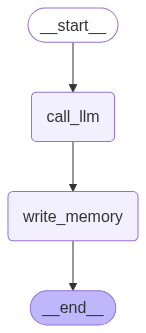

In [91]:
# Graph
graph_builder = StateGraph(DataState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="chatbot-with-structured-memory")

# Visualize
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [92]:
config: dict[str, Any] = {"configurable": {"thread_id": "1", "user_id": "1"}}
msgs = ["Hello, my name is Neidu"]
input_state = DataState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our interaction, so everything we chat about will be a new start. How can I assist you today, Neidu?


In [93]:
msgs = ["I'm an AI Engineer whos's currently working on NLP related things"]
input_state = DataState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our interaction, so everything we chat about will be a new start. How can I assist you today, Neidu?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello Neidu! It's nice to meet you. I'm happy to help you with any questions or topics you'd like to discuss. Since we just started our conversation, I don't have any prior memory of our inter

In [94]:
user_id = "1"
prefix: str = "memory"
key = "user_memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.get(namespace, key)

console.log(existing_memory.value)

[22:31:07] {'memory': {'user_name': 'null', 'interests': ['null']}}                                 ]8;id=18590;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_21152/1135760118.py\1135760118.py]8;;\:]8;id=874538;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_21152/1135760118.py#7\7]8;;\

<br>

### When can this fail?

- with_structured_output is very useful, but what happens if we're working with a more complex schema?
- Here's an example of a more complex schema, which we'll test below.
- This is a Pydantic model that describes a user's preferences for communication and trust fall.

In [ ]:
class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str


class TelegramPreferences(BaseModel):
    preferred_encoding: list[OutputFormat] | None = None
    favorite_telegram_operators: list[OutputFormat] | None = None
    preferred_telegram_paper: list[OutputFormat] | None = None


class MorseCode(BaseModel):
    preferred_key_type: list[OutputFormat] | None = None
    favorite_morse_abbreviations: list[OutputFormat] | None = None


class Semaphore(BaseModel):
    preferred_flag_color: list[OutputFormat] | None = None
    semaphore_skill_level: list[OutputFormat] | None = None


class TrustFallPreferences(BaseModel):
    preferred_fall_height: list[OutputFormat] | None = None
    trust_level: list[OutputFormat] | None = None
    preferred_catching_technique: list[OutputFormat] | None = None


class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore


class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences


class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [ ]:
from json import JSONDecodeError

from pydantic import ValidationError

# Now, let's try extraction of this schema using the with_structured_output method.
# Bind schema to model
llm_with_structure = llm.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation: str = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    response = llm_with_structure.invoke(
        f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>"""
    )
except (ValidationError, JSONDecodeError) as e:
    print(e)

In [ ]:
# console.print(response)

### Trustcall For Creating and Updating Profile Schemas

- As we can see, working with schemas can be tricky. Complex schemas can be difficult to extract.
- In addition, updating even simple schemas can pose challenges.

- Consider our above chatbot.
- We regenerated the profile schema from scratch each time we chose to save a new memory.
- This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.
- Worse, we may loose information when regenerating the profile from scratch.
- Addressing these problems is the motivation for TrustCall!
- It's motivated by exactly these challenges while working on memory.

Let's first show simple usage of extraction with TrustCall on this list of messages.

In [ ]:
# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer whos's currently working on NLP related things"),
]

conversation

- We use `create_extractor`, passing in the model and schema as a tool 
- `TrustCall` allows supplying the schema in various formats, such as `JSON`, `Python dictionaries`, or `Pydantic` models 
- Internally, TrustCall uses tool calling to generate structured output from message inputs 
- To enforce structured output, we can include the schema name in the tool_choice argument 
- The extractor can then be invoked with a conversation to produce validated, structured results.

<br>

### Note

- From my experience, I noticed `trustcall` performs better with larger LLMs .e.g. GPT, Gemini models.

In [ ]:
model_str: str = f"openai:{ModelEnum.GPT_4_o_MINI_REMOTE.value}"
llm: BaseChatModel = init_chat_model(
    model=model_str,
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    seed=0,
)

# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer whos's currently working on NLP related things"),
]

In [ ]:
from trustcall import create_extractor


class UserProfileSchema(BaseModel):
    user_name: str = Field(description="User's preferred name")
    interests: list[str] = Field(default_factory=list, description="User's interests")


trustcall_extractor = create_extractor(
    llm,
    tools=[UserProfileSchema],
    tool_choice="UserProfileSchema",
)
system_message = "Extract the user profile from the following conversation."

# Invoke the extractor
result = await trustcall_extractor.ainvoke(
    {"messages": [SystemMessage(content=system_message)] + conversation}
)

console.print(result)

In [ ]:
for m in result["messages"]:
    m.pretty_print()

In [ ]:
schema = result["responses"][0]
schema

In [ ]:
schema.model_dump()

In [ ]:
result["response_metadata"]

#### Update Conversations

In [ ]:
updated_conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer whos's currently working on NLP related things"),
    AIMessage(
        content="That sounds fascinating! NLP is a really exciting and impactful field in AI. "
        "What will you like to know about AI?"
    ),
    HumanMessage(
        content="Thanks! I'm curious about the latest advancements in AI and how "
        "they're being applied in real-world applications. I'm also interested in "
        "agentic AI workflow"
    ),
]

system_message = """
<system>
Update the memory (JSON doc) to incorporate new information from the following conversation
</system>
"""

result = await trustcall_extractor.ainvoke(
    {"messages": [SystemMessage(content=system_message)] + updated_conversation},
    {"existing": {"UserProfileSchema": schema.model_dump()}},
)


for m in result["messages"]:
    m.pretty_print()

In [ ]:
result["response_metadata"]

In [ ]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

#### Test Trustcall Using The Previously Failed Example

- Unfortunately, the example is still failing.

In [ ]:
# Bind schema to model using trustcall
bound = create_extractor(
    llm,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation: str = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    response = await bound.ainvoke(
        f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>"""
    )
except (ValidationError, JSONDecodeError) as e:
    print(e)

response["responses"][0]

In [ ]:
response["responses"]

## Chatbot With Profile Schema Updating

In [ ]:
model_str: str = f"openai:{ModelEnum.GEMINI_2p5_FLASH_REMOTE.value}"
llm: BaseChatModel = init_chat_model(
    model=model_str,
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    seed=0,
)


class UserProfileSchema(BaseModel):
    """A schema for storing user profile information."""

    user_name: str = Field(description="User's preferred name")
    user_location: str = Field(description="User's location")
    interests: list[str] = Field(default_factory=list, description="User's interests")


trustcall_extractor = create_extractor(
    llm,
    tools=[UserProfileSchema],
    tool_choice="UserProfileSchema",
)

MODEL_SYSTEM_MESSAGE: str = """
<system>

<role>
You are a helpful assistant with memory that responds to the user in a conversational way. 
If you have memory for this user, use it to personalize your responses.
</role>

<memory>
{memory}
</memory>

</system>
"""

# Extraction instruction
TRUSTCALL_INSTRUCTION: str = """
<instruction>
Create or update the memory (JSON doc) to incorporate information from the following conversation:
</instruction>
"""

In [ ]:
async def call_llm(state: DataState, config: RunnableConfig, store: BaseStore) -> dict[str, Any]:
    user_id: str = config["configurable"]["user_id"]

    prefix: str = "memory"
    key: str = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    # Respond using memory + chat history
    response = await llm.ainvoke([SystemMessage(content=system_message)] + state["messages"])
    # Validate
    output = {"messages": [response]}
    validate_data(data=output, state=state, response_model=DataStateValidator)

    return output


async def write_memory(state: DataState, config: RunnableConfig, store: BaseStore) -> None:
    user_id: str = config["configurable"]["user_id"]

    prefix: str = "memory"
    key: str = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)

    # Get the profile and convert to JSON doc
    existing_profile = {"UserProfileSchema": existing_memory.value} if existing_memory else None
    # Invoke the extractor
    result = await trustcall_extractor.ainvoke(
        {
            "messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"],
            "existing": existing_profile,
        },
    )
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()
    # Save the updated profile
    store.put(namespace, key, updated_profile)

In [ ]:
graph_builder = StateGraph(DataState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="Chatbot-with-user-profile")


# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
config: dict[str, Any] = {"configurable": {"thread_id": "1"}, "user_id": "1"}
input_msg: list[Any] = [
    HumanMessage(content="hello, my name is Chinedu. I live in Lagos, Nigeria.")
]


async for event in graph.astream({"messages": input_msg}, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
across_thread_memory.get(("memory", "1"), "user_memory")

In [ ]:
input_msg = ["I'm an AI Engineer whos's currently working on NLP related things"]

async for event in graph.astream({"messages": input_msg}, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
# namespace for the memory to save
user_id: str = "1"
prefix: str = "memory"
key = "user_memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.get(namespace, key)
existing_memory.dict()

<br>

## [TOP](#top)

<br>

<a id="chatbot-with-profile-collection"></a>
## Chatbot with Profile Collection

- Sometimes we want to save memories to a `collection` rather than single profile.
- We'll update our chatbot to save memories to a collection.


In [ ]:
model_str: str = f"openai:{ModelEnum.GPT_4_o_MINI_REMOTE.value}"
llm: BaseChatModel = init_chat_model(
    model=model_str,
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    seed=0,
)


class Memory(BaseModel):
    content: str = Field(description="The main content of the memory.")


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories.", default_factory=[])

In [ ]:
llm_with_structure = llm.with_structured_output(MemoryCollection)
memory_collection = await llm_with_structure.ainvoke(
    [HumanMessage(content="My name is Neidu. I love reading books.")]
)

console.log(memory_collection)